# MODELS Net

## Libraries

In [2]:
import numpy
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Activation
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate
tf.keras.layers.Concatenate()
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from keras.layers.core import Reshape
from keras import optimizers
from tensorflow.keras import regularizers
from keras import Input, Model
from time import time
import time as tm
from keras.initializers import Constant, RandomNormal, glorot_normal
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers import  concatenate

from tfkan.layers import DenseKAN
from tfkan.layers import Conv2DKAN
from tfkan.layers import base

## 30 SRM filters for preprocessing and the activation function

In [13]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################
def thtanh(x,t):
    th=K.tanh(x)*t
    return th

(5, 5, 1, 30)


## Gbras-Net architecture

In [21]:
def GBRAS_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding="same", activation="leaky_relu", depth_multiplier=1, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), strides=(1,1), padding='same', activation="elu",depth_multiplier=3, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding="same", activation="leaky_relu", depth_multiplier=1, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="leaky_relu",depth_multiplier=3, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)

    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(skip1)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
   
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 6
    layers = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding="same", activation="leaky_relu", depth_multiplier=1, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #Layer 7
    layers = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding="same", activation="leaky_relu", depth_multiplier=1, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="leaky_relu",depth_multiplier=3, kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    
    skip2 =   tf.keras.layers.Add()([layers3, layers4])
    #Layer 10
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(skip2)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #Layer 11
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="leaky_relu", padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True)(layers)
    #Layer 15
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #FC
    layers = tf.keras.layers.Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)

    #Layer 18
    layers = DenseKAN(2)(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.95)
    print ("Model GBRAS-Net Generated")
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Defining different functions to work with the architecture

In [6]:

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, model_name="", num_test=""):
    start_time = tm.time()
    log_dir="D:/testing_"+num_test+"/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1
    )
    model.reset_states()
    history=model.fit(X_train, y_train, epochs=epochs, 
                        callbacks=[tensorboard,  checkpoint], 
                        batch_size=batch_size,
                        validation_data=(X_valid, y_valid),
                        initial_epoch=initial_epoch)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir="D:/testing_"+num_test+"/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [7]:
def Final_Results_Test(model,PATH_trained_models):
    B_accuracy = 0 #B --> Best
    for filename in os.listdir(PATH_trained_models):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n') 
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [8]:
from tqdm import tqdm
def plot_train_valid(model,PATH_trained_models,model_name):
    acc_train=[]
    acc_valid=[]
    loss_train=[]
    loss_valid=[]
    for filename in tqdm(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
            acc_train.append(accuracy)
            loss_train.append(loss)
            loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
            acc_valid.append(accuracy)
            loss_valid.append(loss)

    results_dir="D:/modelos/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

   
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(acc_train)
        plt.plot(acc_valid)
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(loss_train)
        plt.plot(loss_valid)
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
    return results

## Plot ROC curves

In [7]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_curve(gt, pred, target_names,model_name):
    labels=[]
    for i in range(len(target_names)):
        
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = model_name+target_names[i] + " AUC: %.3f " % auc_roc
        labels.append(label)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                  fancybox=True, ncol=1)
      
    return [a,b],labels
labels = ["Cover","Stego"]

## Working with BOSSbase 1.01 WOW y PAYLOAD = 0.4bpp

In the README, there is a link to download the databases we use for the work. There are two databases BOSSbase 1.01 and Bows2+ BOSSbase 1.01, cover images and stego. You can choose the payload of 0.2 and 0.4 bpp for each of the databases.

In [9]:
#Train
X_train = np.load('data_load/X_train.npy')
y_train = np.load('data_load/y_train.npy')
#Valid
X_valid = np.load('data_load/X_valid.npy')
y_valid = np.load('data_load/y_valid.npy')
#Test
X_test = np.load('data_load/X_test.npy')
y_test = np.load('data_load/y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


## CNN name and algorithm 

In [23]:
base_name="04S-UNIWARD"

In [22]:
model= GBRAS_Net() 
model.summary()

Model GBRAS-Net Generated
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 30  780         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 30  90         ['conv2d[0][0]']                 
 alization)                     )                                   

## Training gbras-net

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.5008
Epoch 1: val_accuracy improved from -inf to 0.51200, saving model to D:/testing_6_GBRAS_MOD/Model_GBRAS_net_04S-UNIWARD_1729094797.7765627\saved-model.hdf5
250/250 [==============================] - 69s 263ms/step - loss: 1.0144 - accuracy: 0.5008 - val_loss: 1.0122 - val_accuracy: 0.5120
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.5173
Epoch 2: val_accuracy improved from 0.51200 to 0.52500, saving model to D:/testing_6_GBRAS_MOD/Model_GBRAS_net_04S-UNIWARD_1729094797.7765627\saved-model.hdf5
250/250 [==============================] - 65s 262ms/step - loss: 1.0113 - accuracy: 0.5173 - val_loss: 1.0081 - val_accuracy: 0.5250
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.0022 - accuracy: 0.5451
Epoch 3: val_accuracy improved from 0.52500 to 0.56550, saving model to D:/testing_6_GBRAS_MOD/Model_GBRAS_net_04S-UNIWARD_172

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


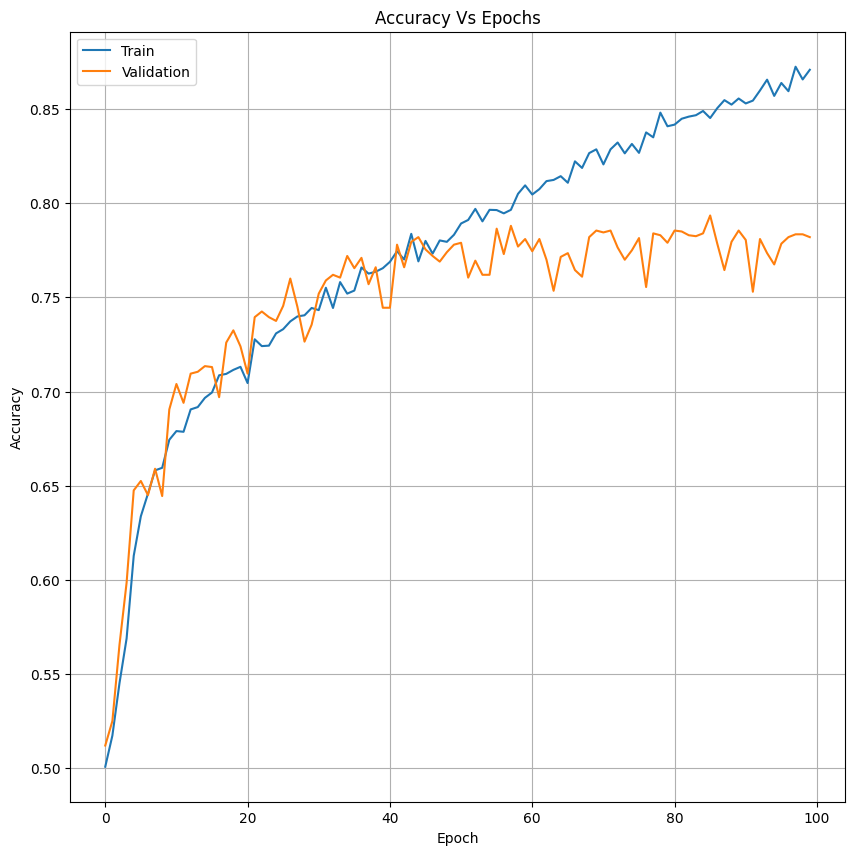

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


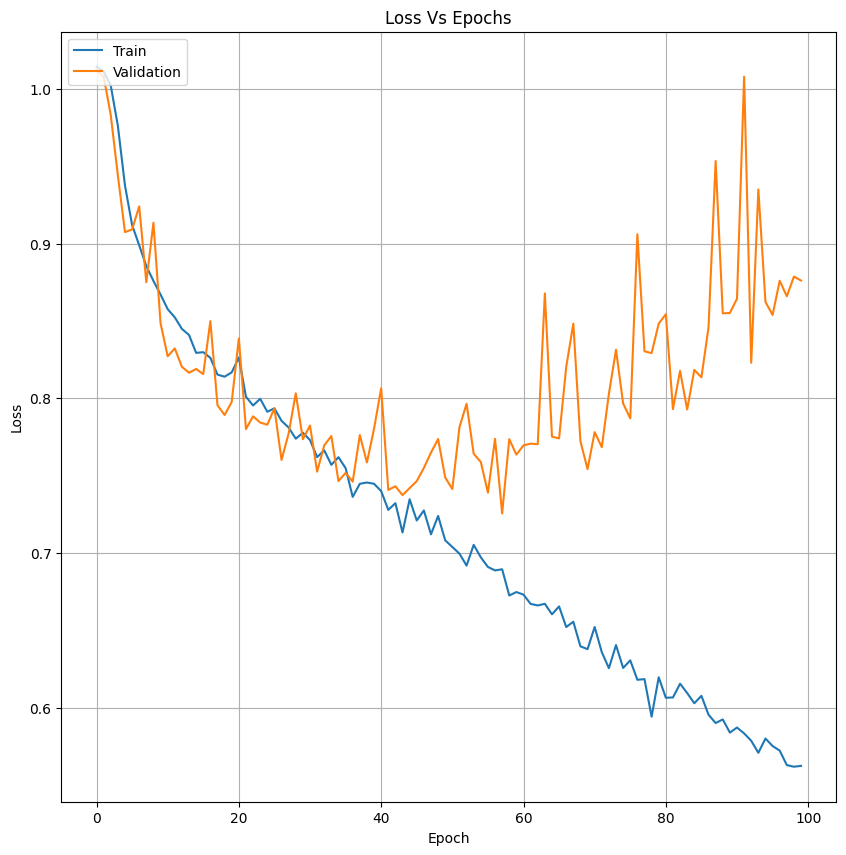

Time Model_GBRAS_net_04S-UNIWARD = 6337.152960538864 [seconds]


In [24]:
name="Model_"+'GBRAS_net'+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name=name, num_test='6_GBRAS_MOD')